# Udacity PyTorch Scholarship Final Lab Challenge

**By [Droid(Kaggle - Droid021)](https://www.linkedin.com/in/v3nvince)**

In [0]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 57.9MB/s 


In [0]:
#!wget 'https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip'
#!unzip flower_data.zip

In [0]:
#!pip3 install torch==0.4.0 torchvision

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

In [0]:
data_dir = 'flower_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=80, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=80)

In [0]:
model = models.resnet18(pretrained=True)

In [0]:
# Freeze parameters so we don't backprop through them
for _, param in model.named_parameters():
  param.requires_grad = False
  
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.4)),
    ('fc2', nn.Linear(512, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))
    
model.fc = classifier

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.005)

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 30

valid_loss_min = np.Inf

# Some lists to keep track of loss and accuracy during each epoch
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
# Start epochs
for epoch in range(epochs):
    
    #adjust_learning_rate(optimizer, epoch)
    
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # Set the training mode ON -> Activate Dropout Layers
    model.train() # prepare model for training
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    # Load Train Images with Labels(Targets)
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        if type(output) == tuple:
            output, _ = output
        
        # Calculate Training Accuracy 
        predicted = torch.max(output.data, 1)[1]        
        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += (predicted == target).sum()
        
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
  #      from torch.autograd import Variable
 #       loss = Variable(loss, requires_grad = True)
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average training loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Avg Accuracy
    accuracy = 100 * correct / float(total)
    
    # Put them in their list
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    
        
    # Implement Validation like K-fold Cross-validation 
    
    # Set Evaluation Mode ON -> Turn Off Dropout
    model.eval() # Required for Evaluation/Test

    # Calculate Test/Validation Accuracy         
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:


            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Predict Output
            output = model(data)
            if type(output) == tuple:
                output, _ = output

            # Calculate Loss
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
            # Get predictions from the maximum value
            predicted = torch.max(output.data, 1)[1]

            # Total number of labels
            total += len(target)

            # Total correct predictions
            correct += (predicted == target).sum()
    
    # calculate average training loss and accuracy over an epoch
    val_loss = val_loss/len(test_loader.dataset)
    accuracy = 100 * correct/ float(total)
    
    # Put them in their list
    val_acc_list.append(accuracy)
    val_loss_list.append(val_loss)
    
    # Print the Epoch and Training Loss Details with Validation Accuracy   
    print('Epoch: {} \tTraining Loss: {:.4f}\t Val. acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    # save model if validation loss has decreased
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_loss))
        # Save Model State on Checkpoint
        torch.save(model.state_dict(), 'gdrive/My Drive/remodel.pt')
        torch.save(model.state_dict(), 'umodel.pt')
        valid_loss_min = val_loss
    # Move to next epoch
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 3.2448	 Val. acc: 67.00%
Validation loss decreased (inf --> 1.340319).  Saving model ...
Epoch: 2 	Training Loss: 1.8805	 Val. acc: 79.00%
Validation loss decreased (1.340319 --> 0.806241).  Saving model ...
Epoch: 3 	Training Loss: 1.5993	 Val. acc: 80.00%
Validation loss decreased (0.806241 --> 0.708884).  Saving model ...
Epoch: 4 	Training Loss: 1.4636	 Val. acc: 84.00%
Validation loss decreased (0.708884 --> 0.609268).  Saving model ...
Epoch: 5 	Training Loss: 1.4414	 Val. acc: 84.00%
Validation loss decreased (0.609268 --> 0.586282).  Saving model ...
Epoch: 6 	Training Loss: 1.4378	 Val. acc: 84.00%
Validation loss decreased (0.586282 --> 0.548567).  Saving model ...
Epoch: 7 	Training Loss: 1.4294	 Val. acc: 85.00%
Epoch: 8 	Training Loss: 1.3244	 Val. acc: 83.00%
Epoch: 9 	Training Loss: 1.3344	 Val. acc: 86.00%
Validation loss decreased (0.548567 --> 0.469412).  Saving model ...
Epoch: 10 	Training Loss: 1.2951	 Val. acc: 84.00%
Epoch: 11 	Training L

## Links Here:  
**Model State Checkpoint File: [umodel.pt](./umodel.pt)**   (Preferred)  

In [0]:
model.load_state_dict(torch.load('umodel.pt'))

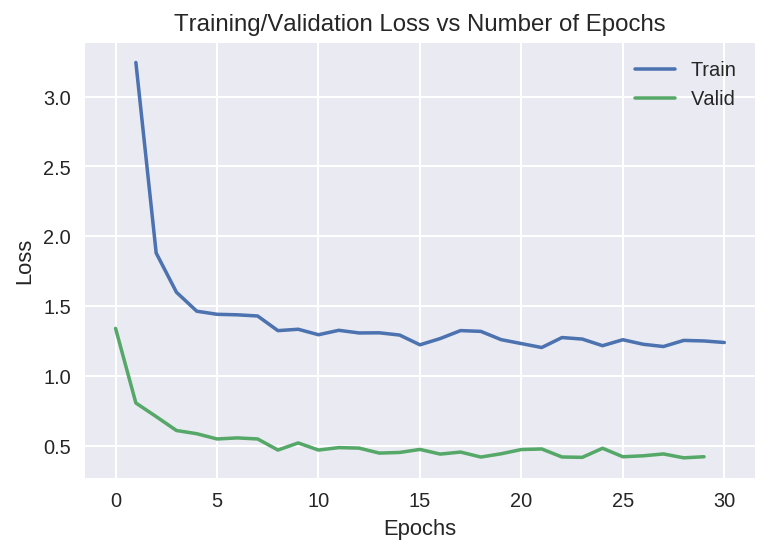

In [26]:
# Training / Validation Loss
plt.plot(epoch_list,train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Validation Loss vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

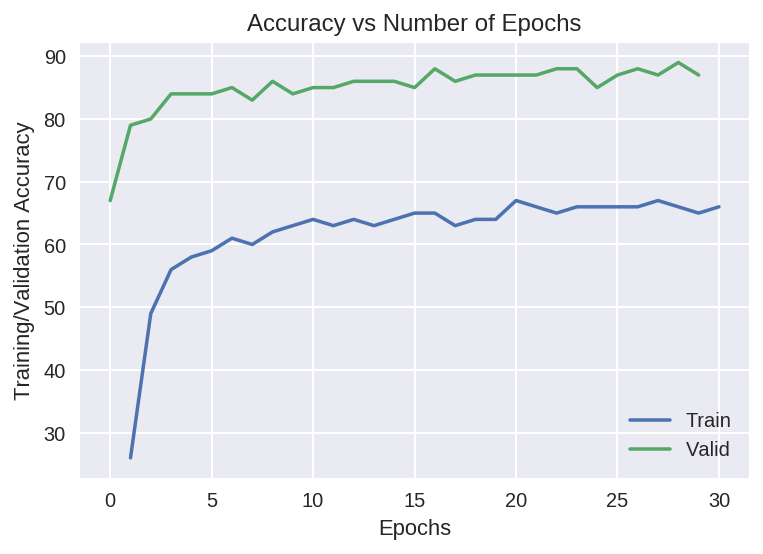

In [27]:
# Train/Valid Accuracy
plt.plot(epoch_list,train_acc_list)
plt.plot(val_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='best')
plt.show()

In [28]:
val_acc = sum(val_acc_list[:]).item()/len(val_acc_list)
print("Validation Accuracy of model = {} %".format(val_acc))

Validation Accuracy of model = 85.0 %


In [29]:
!git clone https://github.com/GabrielePicco/deep-learning-flower-identifier
!pip install airtable
import sys
sys.path.insert(0, 'deep-learning-flower-identifier')

Cloning into 'deep-learning-flower-identifier'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 71 (delta 40), reused 31 (delta 4), pack-reused 0
Unpacking objects: 100% (71/71), done.
  Running setup.py bdist_wheel for airtable ... - done
  Stored in directory: /root/.cache/pip/wheels/9b/ba/63/364c02fabcd50ef6e2f101a57feb727bd7a693697765a9df17
Successfully built airtable


In [30]:
from test_model_pytorch_facebook_challenge import calc_accuracy
calc_accuracy(model, input_image_size=224, use_google_testset=False)

100.0% 35053568 / 35050314


Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.78125
Batch accuracy (Size 32): 0.75
Batch accuracy (Size 32): 0.78125
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.8125
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 0.6875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.75
Batch accuracy (Size 32): 0.8125
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 0.75
Batch accuracy (Size 32): 0.8125
Batch accuracy (Size 32): 0.8125
Batch accuracy (Size 32): 0.75
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.8421052694320679
Mean accuracy: 0.8376771211624146


0.8376771